## Лабораторная работа 4.

## Группа: РИМ-211060

### ФИО:
#### Степаненко Дмитрий Владимирович

## 0. Цель работы: изучить основы корреляционного анализа данных.

### Задание:
#### 1) Загрузить данные из файла SacramentocrimeJanuary2006.csv .
#### 2) определить коэффициенты корреляции между количеством правонарушений, совершаемых за день, на протяжении месяца в северной, южной и центральной частями Сакраменто.

### Замечание: необходимо определить крайние северную и южную точки выборки их считать границами города. Город необходимо разбить с севера на юг на три равные зоны.

## 1. Сначала импортируйте в свой код нужные библиотеки, функции и т.д.


In [263]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from scipy import signal
import scipy.stats as stats
from statsmodels.tsa import api as tsa
%matplotlib inline
from scipy.optimize import curve_fit
import pandas as pd
import os
import datetime
import calendar

## 2. Загрузим данные из БД о преступлениях из Сакраменто для нашего анализа:

In [264]:
crime = pd.read_csv('SacramentocrimeJanuary2006.csv', encoding = 'cp1251', sep = ',')

In [265]:
crime.columns

Index(['cdatetime', 'address', 'district', 'beat', 'grid', 'crimedescr',
       'ucr_ncic_code', 'latitude', 'longitude'],
      dtype='object')

In [266]:
crime.head()

,cdatetime,address,district,beat,grid,crimedescr,ucr_ncic_code,latitude,longitude
0,1/1/06 0:00,3108 OCCIDENTAL DR,3,3C,1115,10851(A)VC TAKE VEH W/O OWNER,2404,38.550420,-121.391416
1,1/1/06 0:00,2082 EXPEDITION WAY,5,5A,1512,459 PC BURGLARY RESIDENCE,2204,38.473501,-121.490186
2,1/1/06 0:00,4 PALEN CT,2,2A,212,10851(A)VC TAKE VEH W/O OWNER,2404,38.657846,-121.462101
3,1/1/06 0:00,22 BECKFORD CT,6,6C,1443,476 PC PASS FICTICIOUS CHECK,2501,38.506774,-121.426951
4,1/1/06 0:00,3421 AUBURN BLVD,2,2A,508,459 PC BURGLARY-UNSPECIFIED,2299,38.637448,-121.384613


In [267]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7584 entries, 0 to 7583
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cdatetime      7584 non-null   object 
 1   address        7584 non-null   object 
 2   district       7584 non-null   int64  
 3   beat           7584 non-null   object 
 4   grid           7584 non-null   int64  
 5   crimedescr     7584 non-null   object 
 6   ucr_ncic_code  7584 non-null   int64  
 7   latitude       7584 non-null   float64
 8   longitude      7584 non-null   float64
dtypes: float64(2), int64(3), object(4)
memory usage: 533.4+ KB


In [268]:
crime.describe()

,district,grid,ucr_ncic_code,latitude,longitude
count,7584.000000,7584.000000,7584.000000,7584.000000,7584.000000
mean,3.574631,916.250791,4275.068829,38.559809,-121.463832
std,1.642512,407.436310,2171.593193,0.056101,0.034621
min,1.000000,102.000000,909.000000,38.437999,-121.555832
25%,2.000000,567.000000,2309.000000,38.518476,-121.489543
50%,3.000000,899.000000,3532.000000,38.559523,-121.465459
75%,5.000000,1264.000000,7000.000000,38.610361,-121.435947
max,6.000000,1661.000000,8102.000000,38.683789,-121.365238


## 3. Отобразим графически гистограмму по преступлениям в разных округах:

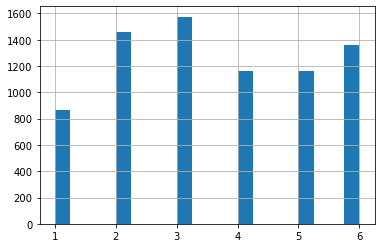

In [269]:
crime.district.hist(bins=20)
plt.show()

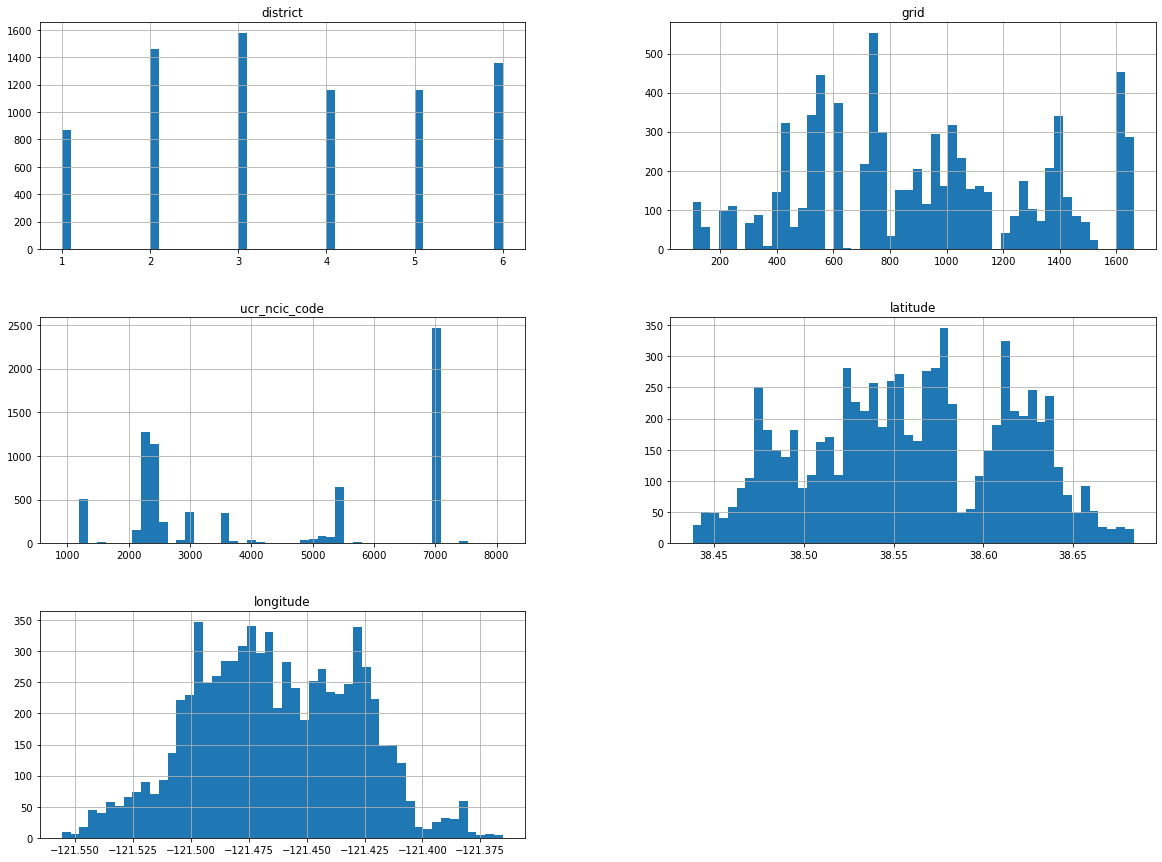

In [270]:
crime.hist(bins=50, figsize= (20, 15))
plt.show()

In [271]:
type1 = pd.DataFrame(crime['crimedescr'])
type1.describe()

type2 = crime['crimedescr']
values = []

for i in range(len(type2)):
    if type2[i] not in values:
        values.append(type2[i])
        
values

['10851(A)VC TAKE VEH W/O OWNER',
 '459 PC  BURGLARY RESIDENCE',
 '476 PC PASS FICTICIOUS CHECK',
 '459 PC  BURGLARY-UNSPECIFIED',
 '530.5 PC USE PERSONAL ID INFO',
 '459 PC  BURGLARY VEHICLE',
 '484 PC   PETTY THEFT/INSIDE',
 '459 PC  BURGLARY BUSINESS',
 '1708 US   THEFT OF MAIL',
 'ASSAULT WITH WEAPON - I RPT',
 'SUSP PERS-NO CRIME - I RPT',
 '484G(B) PC ACCESS CARD FRAUD',
 '487(A) PC GRAND THEFT',
 'TELEPEST -I RPT',
 '487(A) GRAND THEFT-INSIDE',
 '484J PC PUBLISH CARD INFO',
 '484 PC PETTY THEFT',
 'TRAFFIC - I RPT',
 '594(B)(1)PC  VANDALISM +$400',
 '484 PC  PETTY THEFT/ OUTSIDE',
 'HARASSMENT - I RPT',
 'LOST PROPERTY - I RPT',
 '484G(A)PC USE FORGED CARD',
 '503 PC   EMBEZZLEMENT',
 '653M(A) PC OBSCENE/THREAT CALL',
 '484 PETTY THEFT/LICENSE PLATE',
 'FOUND PROPERTY - I RPT',
 'THREATS - I RPT',
 '530 PC FALSE PERS. REC PROP',
 '246 PC SHOOT OCCUP DWELL/VEH',
 'SHOOT INTO OCCUP DWELL - I RPT',
 '243(E)1 BATTERY NONCOHAB SPOUS',
 'MISCELLANEOUS I RPT (ZMISC)',
 'TOWED/STORED VE

In [272]:
type1.count()

crimedescr    7584
dtype: int64

In [273]:
s = type1['crimedescr'].value_counts()
t = type1['crimedescr'].value_counts().index.tolist()

r = pd.Series(s.head(65))
q = pd.Series(s.head(65))

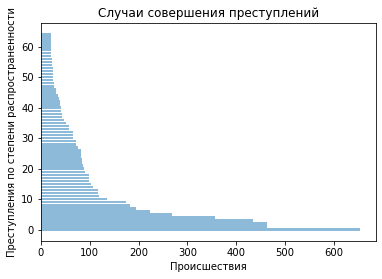

In [274]:
y_pos = np.arange(len(r))
plt.barh(y_pos, q, align='center', alpha=0.5)
plt.xlabel('Происшествия')
plt.ylabel('Преступления по степени распространенности')
plt.title('Случаи совершения преступлений')

plt.show()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

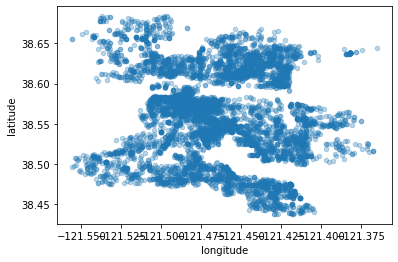

In [275]:
crime.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3)

## 4. Построим матрицу корреляции и график рассеяния и плотности через функции:

In [276]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [277]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) 
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    columnNames = list(df)
    if len(columnNames) > 10:
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [278]:
crime.dataframeName = 'SacramentocrimeJanuary2006.csv'
nRow, nCol = crime.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 7584 rows and 9 columns


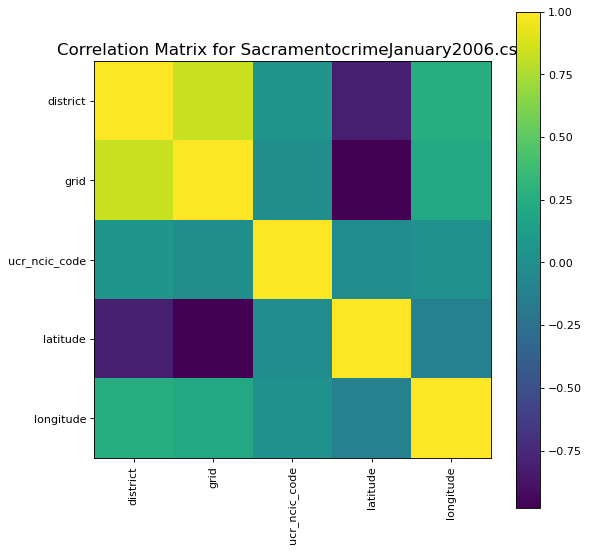

In [279]:
plotCorrelationMatrix(crime, 8)

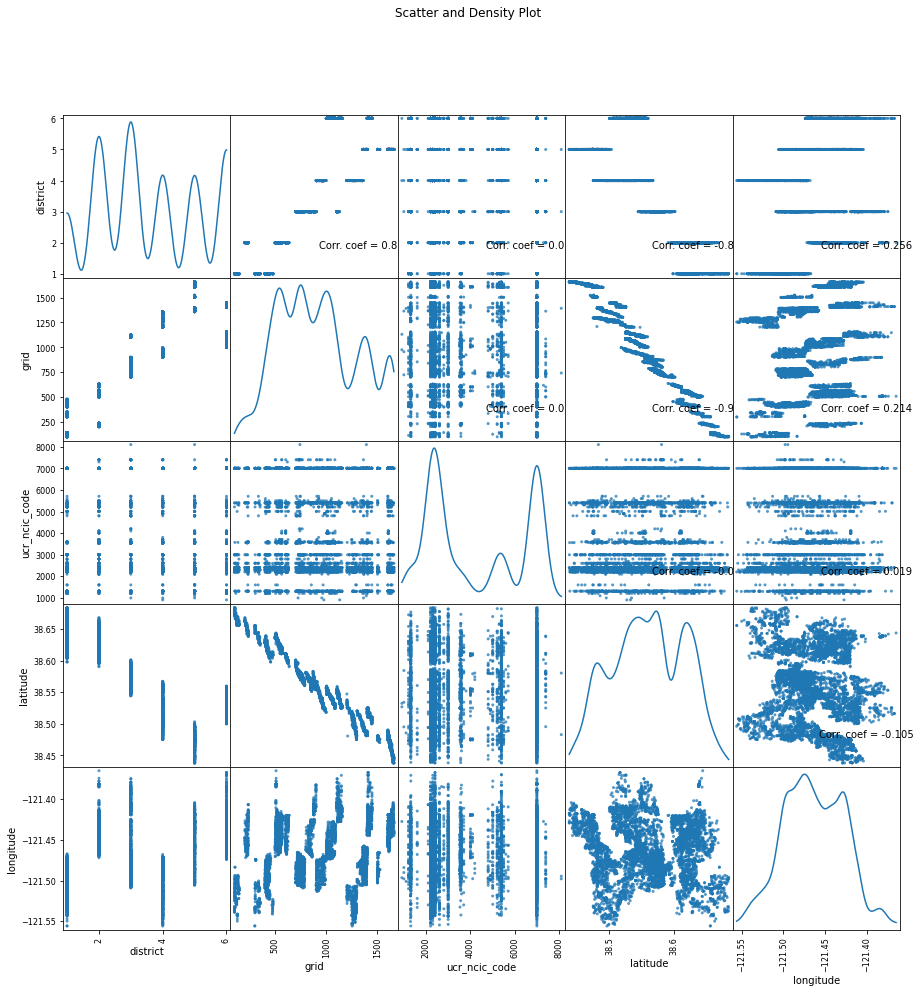

In [280]:
plotScatterMatrix(crime, 15, 10)

### 5. Определить коэффициенты корреляции между количеством правонарушений, совершаемых за день, на протяжении месяца в северной, южной и центральной частями Сакраменто.

In [281]:
# Вернёмся к переменной crime
crime

,cdatetime,address,district,beat,grid,crimedescr,ucr_ncic_code,latitude,longitude
0,1/1/06 0:00,3108 OCCIDENTAL DR,3,3C,1115,10851(A)VC TAKE VEH W/O OWNER,2404,38.550420,-121.391416
1,1/1/06 0:00,2082 EXPEDITION WAY,5,5A,1512,459 PC BURGLARY RESIDENCE,2204,38.473501,-121.490186
2,1/1/06 0:00,4 PALEN CT,2,2A,212,10851(A)VC TAKE VEH W/O OWNER,2404,38.657846,-121.462101
3,1/1/06 0:00,22 BECKFORD CT,6,6C,1443,476 PC PASS FICTICIOUS CHECK,2501,38.506774,-121.426951
4,1/1/06 0:00,3421 AUBURN BLVD,2,2A,508,459 PC BURGLARY-UNSPECIFIED,2299,38.637448,-121.384613
...,...,...,...,...,...,...,...,...,...
7579,1/31/06 23:36,26TH ST / G ST,3,3B,728,594(B)(2)(A) VANDALISM/ -$400,2999,38.577832,-121.470460
7580,1/31/06 23:40,4011 FREEPORT BLVD,4,4A,957,459 PC BURGLARY BUSINESS,2203,38.537591,-121.492591
7581,1/31/06 23:41,30TH ST / K ST,3,3C,841,TRAFFIC-ACCIDENT INJURY,5400,38.572030,-121.467012
7582,1/31/06 23:45,5303 FRANKLIN BLVD,4,4B,969,3056 PAROLE VIO - I RPT,7000,38.527187,-121.471248


In [282]:
# Отформатируем main table по формату дат
crime['cdatetime'] = pd.to_datetime(crime['cdatetime'], format= '%m/%d/%y %H:%M')
crime

,cdatetime,address,district,beat,grid,crimedescr,ucr_ncic_code,latitude,longitude
0,2006-01-01 00:00:00,3108 OCCIDENTAL DR,3,3C,1115,10851(A)VC TAKE VEH W/O OWNER,2404,38.550420,-121.391416
1,2006-01-01 00:00:00,2082 EXPEDITION WAY,5,5A,1512,459 PC BURGLARY RESIDENCE,2204,38.473501,-121.490186
2,2006-01-01 00:00:00,4 PALEN CT,2,2A,212,10851(A)VC TAKE VEH W/O OWNER,2404,38.657846,-121.462101
3,2006-01-01 00:00:00,22 BECKFORD CT,6,6C,1443,476 PC PASS FICTICIOUS CHECK,2501,38.506774,-121.426951
4,2006-01-01 00:00:00,3421 AUBURN BLVD,2,2A,508,459 PC BURGLARY-UNSPECIFIED,2299,38.637448,-121.384613
...,...,...,...,...,...,...,...,...,...
7579,2006-01-31 23:36:00,26TH ST / G ST,3,3B,728,594(B)(2)(A) VANDALISM/ -$400,2999,38.577832,-121.470460
7580,2006-01-31 23:40:00,4011 FREEPORT BLVD,4,4A,957,459 PC BURGLARY BUSINESS,2203,38.537591,-121.492591
7581,2006-01-31 23:41:00,30TH ST / K ST,3,3C,841,TRAFFIC-ACCIDENT INJURY,5400,38.572030,-121.467012
7582,2006-01-31 23:45:00,5303 FRANKLIN BLVD,4,4B,969,3056 PAROLE VIO - I RPT,7000,38.527187,-121.471248


In [283]:
# Выполним сортировку по широте, учитывая minmax значений. Вычислим "спред" по трём равным частям города: север, центр, юг.
crime_latitude = crime.sort_values(by = 'latitude')
crime_latitude

,cdatetime,address,district,beat,grid,crimedescr,ucr_ncic_code,latitude,longitude
7515,2006-01-31 18:09:00,CENTER PKWY / BRUCEVILLE RD,5,,1654,20001(A) VC HIT/RUN INJ/DEATH,5401,38.437999,-121.417761
2621,2006-01-11 22:00:00,BRUCEVILLE RD / CENTER PKWY,5,,1654,484 PETTY THEFT/LICENSE PLATE,2399,38.437999,-121.417761
2333,2006-01-10 23:35:00,6440 FIELDALE DR,5,5C,1661,TOWED/STORED VEHICLE,7000,38.438098,-121.429271
2332,2006-01-10 23:35:00,6440 FIELDALE DR,5,5C,1661,TOWED/STORED VEHICLE,7000,38.438098,-121.429271
3994,2006-01-17 16:58:00,6560 KENBRIDGE ST,5,5C,1661,10851 VC AUTO THEFT LOCATE,2404,38.438116,-121.426723
...,...,...,...,...,...,...,...,...,...
3295,2006-01-14 16:00:00,5930 MEEKS WAY,1,1A,106,1708 US THEFT OF MAIL,2310,38.683391,-121.496352
3420,2006-01-15 02:05:00,5832 LOLET WAY,1,1A,102,MISCELLANEOUS I RPT (ZMISC),7000,38.683412,-121.532093
1830,2006-01-08 23:49:00,1641 HALO WAY,1,1A,106,10851(A)VC TAKE VEH W/O OWNER,2404,38.683599,-121.498610
6169,2006-01-26 09:00:00,360 ALLAIRE CIR,1,1A,102,459 PC BURGLARY RESIDENCE,2204,38.683633,-121.537304


In [284]:
crime_latitude_max = crime[crime['latitude'] == crime['latitude'].max()]
crime_latitude_max

,cdatetime,address,district,beat,grid,crimedescr,ucr_ncic_code,latitude,longitude
1420,2006-01-07 00:01:00,5948 MEEKS WAY,1,1A,106,1708 US THEFT OF MAIL,2310,38.683789,-121.496349


In [285]:
crime_max = crime['latitude'].max()
crime_max

38.68378949

In [286]:
crime_latitude_min = crime[crime['latitude'] == crime['latitude'].min()]
crime_latitude_min

,cdatetime,address,district,beat,grid,crimedescr,ucr_ncic_code,latitude,longitude
2621,2006-01-11 22:00:00,BRUCEVILLE RD / CENTER PKWY,5,,1654,484 PETTY THEFT/LICENSE PLATE,2399,38.437999,-121.417761
7515,2006-01-31 18:09:00,CENTER PKWY / BRUCEVILLE RD,5,,1654,20001(A) VC HIT/RUN INJ/DEATH,5401,38.437999,-121.417761


In [287]:
crime_min = crime['latitude'].min()
crime_min

38.43799945

In [288]:
spred = (crime_max - crime_min) / 3
spred

0.08193001333333427

In [289]:
# Далее проведем выборку crime по датам (месяц, день)
crime_day = crime[['cdatetime','address', 'latitude']]
crime_day.cdatetime = pd.to_datetime(crime.cdatetime)
crime_day['DAY'] = crime_day.cdatetime.dt.day 
crime_day

C:\Users\dusta\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-289-4471a57ac9c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_day['DAY'] = crime_day.cdatetime.dt.day


,cdatetime,address,latitude,DAY
0,2006-01-01 00:00:00,3108 OCCIDENTAL DR,38.550420,1
1,2006-01-01 00:00:00,2082 EXPEDITION WAY,38.473501,1
2,2006-01-01 00:00:00,4 PALEN CT,38.657846,1
3,2006-01-01 00:00:00,22 BECKFORD CT,38.506774,1
4,2006-01-01 00:00:00,3421 AUBURN BLVD,38.637448,1
...,...,...,...,...
7579,2006-01-31 23:36:00,26TH ST / G ST,38.577832,31
7580,2006-01-31 23:40:00,4011 FREEPORT BLVD,38.537591,31
7581,2006-01-31 23:41:00,30TH ST / K ST,38.572030,31
7582,2006-01-31 23:45:00,5303 FRANKLIN BLVD,38.527187,31


In [290]:
# crimes per day
crimes_per_day = crime_day.value_counts('DAY')
crimes_per_day = pd.DataFrame(crimes_per_day)
crimes_per_day = crimes_per_day.sort_values(by = 'DAY')

crimes_per_day

,0
DAY,
1,250
2,145
3,256
4,257
5,268
6,233
7,242
8,182
9,261


In [291]:
# Определим crimes по городским зонам
crime_north = crime_day[(crime_day['latitude'] >=  crime_min + spred + spred) &
   (crime_day['latitude'] <= crime_max)].value_counts('DAY')

crime_north = pd.DataFrame(crime_north)
crime_north = crime_north.sort_values(by = 'DAY')

crime_centre = crime_day[(crime_day['latitude'] >= crime_min + spred) &
   (crime_day['latitude'] < crime_min + spred + spred)].value_counts('DAY')

crime_centre = pd.DataFrame(crime_centre)
crime_centre = crime_centre.sort_values(by = 'DAY')

crime_south = crime_day[(crime_day['latitude'] >= crime_min) &
   (crime_day['latitude'] < crime_min + spred)].value_counts('DAY')

crime_south = pd.DataFrame(crime_south)
crime_south = crime_south.sort_values(by ='DAY')

In [292]:
# Общая оперативная сводка с коэффициентами корреляции
crime_all = pd.DataFrame(crime_south)
crime_all.columns=['South']
crime_all['Centre'] = crime_centre
crime_all['North'] = crime_north

crime_all

,South,Centre,North
DAY,,,
1,60,96,94
2,32,60,53
3,62,116,78
4,68,122,67
5,69,131,68
6,51,108,74
7,74,106,62
8,51,78,53
9,68,117,76


In [293]:
crime_all.corr()

,South,Centre,North
South,1.000000,0.614366,0.440369
Centre,0.614366,1.000000,0.288591
North,0.440369,0.288591,1.000000


In [294]:
corr.style.background_gradient(cmap='coolwarm')

,South,Centre,North
South,1.000000,0.614366,0.440369
Centre,0.614366,1.000000,0.288591
North,0.440369,0.288591,1.000000


### На градиентной тепловой карте темный цвет - высокая корреляция между значениями, светлый - корреляция между переменными. Визуализируем через matplotlib:

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2160x1080 with 0 Axes>

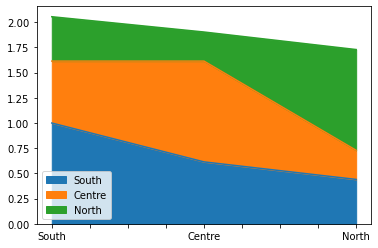

In [295]:
fig = plt.figure(figsize = (30, 15), facecolor = 'peachpuff')
crime_all.corr().plot(kind = 'area')
plt.show

#### В ходе выполнения данной лабораторной работы было рассмотрено практическое применение корреляционного анализа. По итогам работы оценен полученный результат и возможности python-библиотеки - pandas, numpy/scipy, matplotlib. По итогам работы дана обобщённая оценка полученным результатам с учётом возможностей популярных python-библиотек. Кроме того, предложена визуализации данных, по которой можно определить коэффициенты корреляции между количеством правонарушений, совершаемых за день, на протяжении месяца в северной, южной и центральной частями Сакраменто (в зависимости от поставленной задачи).